# Auswertung Aufgaben Zeiten Simpel

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

link = '/Users/janhoffmann/ErledigteAufgaben.csv'
raw = pd.read_csv(link)

In [87]:
# Spalte 'Aufgabentext' in String umwandeln, ausschließlich nach Aufgabe 'Masterarbeit' filtern und Spalte '[Minuten]' umbenennen
raw.Aufgabentext.astype(str)
df = raw[raw.Aufgabentext == 'Masterarbeit']
df = df.rename(columns={'[Minuten]': 'Minuten'})

In [88]:
# Gesamtbearbeitungszeit und durchschnittszeit berechnen und ausgeben
gesamtzeit = df['Minuten'].sum()
print('INSGESAMT verbrachte Zeit [Minuten] mit der Masterarbeit:\n',gesamtzeit)

durchschnittszeit = round(df['Minuten'].mean())
print('\nDie DURCHSCHNITTSZEIT der einzelnen Blöcke beträgt: \n',durchschnittszeit)

INSGESAMT verbrachte Zeit [Minuten] mit der Masterarbeit:
 6944

Die DURCHSCHNITTSZEIT der einzelnen Blöcke beträgt: 
 42


In [89]:
# Calculation DataFrame anlegen, der aus dem originalen df besteht, bei dem die Spalte 'Datum' nach Whitespace gesplittet wurde
df_calc = df[['Wochentag','Monat', 'Tag', 'Uhrzeit', 'Jahr']] = df['Datum'].str.split(expand=True)

# Zusammensetzen der einzelnen Bestandteile zu einem neuen Datumsformat Y-m-d und als Spalte 'Date' in df einfügen
df_calc['Date_new'] = df_calc[2] + '-' + df_calc[1] + '-' + df_calc[4]
df['Date'] = df_calc['Date_new']

In [90]:
# df von den Hilfsspalten befreien
df = df.drop(['Datum', 'Wochentag', 'Monat', 'Tag', 'Uhrzeit', 'Jahr'], axis=1)

In [91]:
# neuen df zur Gruppierung anlegen, nach 'Date' als .sum() gruppieren, index in DateTime umwandeln und nach Index sortieren
df_grouped = df
df_grouped = df_grouped.groupby(by='Date').sum()
df_grouped.index = pd.to_datetime(df_grouped.index)
df_grouped = df_grouped.sort_index()
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2023-01-05 to 2023-03-24
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Minuten  45 non-null     int64
dtypes: int64(1)
memory usage: 720.0 bytes


In [92]:
# Vollständigen Index vom ersten bis zum letzten Tag im Datensatz anlegen, Schrittweite daily
first_day = df_grouped.index[0]
last_day = df_grouped.index[-1]
index_new = pd.date_range(start= first_day, end=last_day)
test = pd.DataFrame(data= np.linspace(0,0,len(index_new)), index= index_new)
test['Minuten'] = test[0]
test = test.drop(0, axis=1)

In [93]:
# Neuen df mit vollständigem Index und ursprünglichen df mergen, Hilfsspalte entfernen und verbleibende Spalte umbenennen
merged = pd.merge(test, df_grouped, left_index=True, right_index=True, how='outer')
merged = merged.drop(['Minuten_x'], axis=1)
merged = merged.rename(columns={'Minuten_y': 'Minuten'}, errors="raise")

In [94]:
# Für fehlende Werte Null einsetzen, Spalten für Durchschnitt und MA/ anlegen und befüllen
merged['Minuten'] = merged['Minuten'].fillna(0)
average = np.linspace(durchschnittszeit,durchschnittszeit, len(merged))
merged['Durchschnitt'] = merged['Minuten'].mean()
merged['MA7'] = merged['Minuten'].rolling(7).mean()

<AxesSubplot:title={'center':'Verteilung der täglichen Arbeitszeit für die Masterarbeit'}>

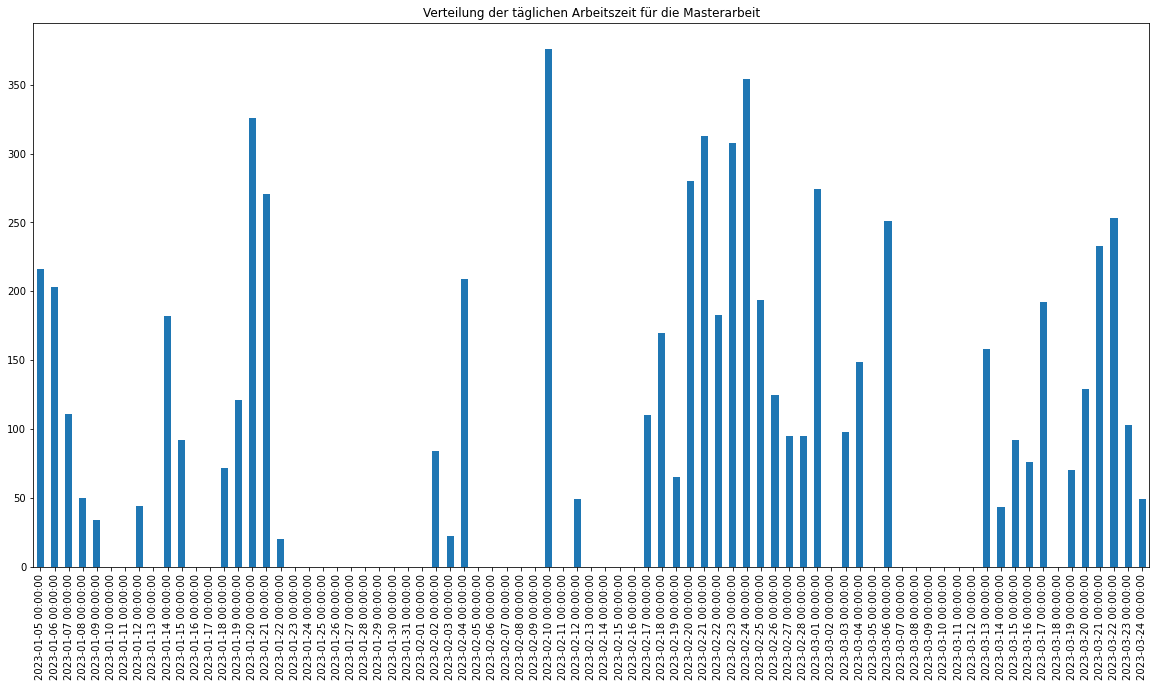

In [95]:
# Tägliche Arbeitszeit Masterarbeit plotten
merged.Minuten.plot(kind='bar', figsize=(20,10), grid=False, title='Verteilung der täglichen Arbeitszeit für die Masterarbeit')

In [96]:
# Letze 7 Tage betrachten
last_week = merged.iloc[-7:]
last_week = last_week.round(0).astype(int)
last_week

,Minuten,Durchschnitt,MA7
2023-03-18,0,88,80
2023-03-19,70,88,90
2023-03-20,129,88,86
2023-03-21,233,88,113
2023-03-22,253,88,136
2023-03-23,103,88,140
2023-03-24,49,88,120


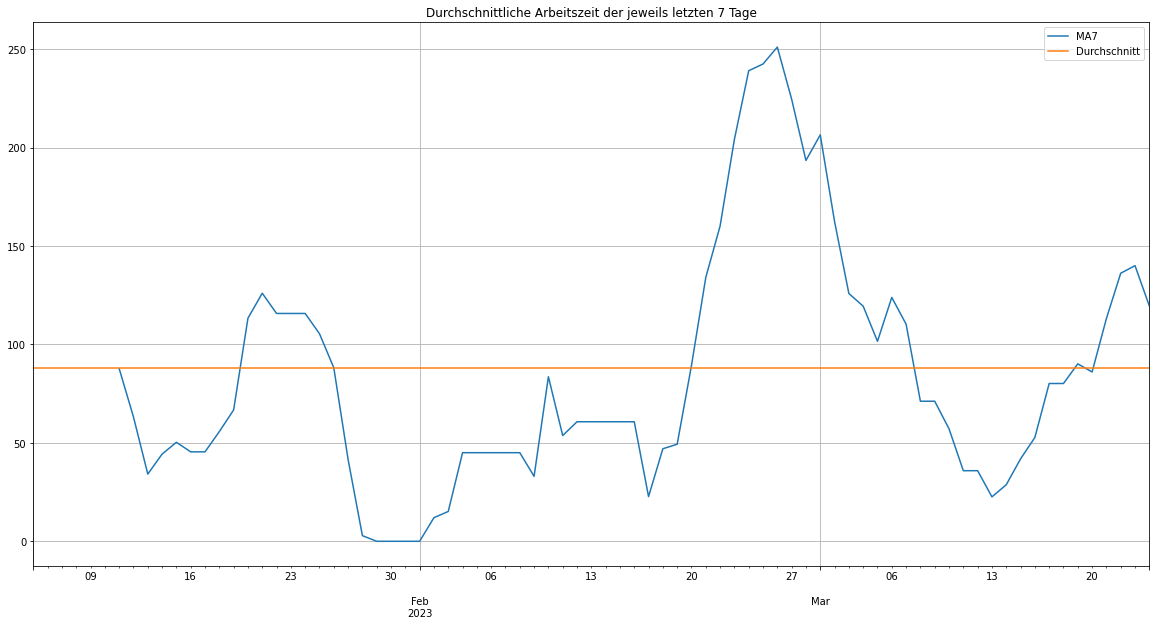

In [97]:
# Durchschnittliche Arbeitszeit Masterarbeit und MA7 plotten und auf dem Desktop speichern
link = '/Users/janhoffmann/Desktop/MA7_und_Average.pdf'
ax = merged[['MA7', 'Durchschnitt']].plot(kind='line', figsize=(20,10), grid=True, title='Durchschnittliche Arbeitszeit der jeweils letzten 7 Tage')
fig = ax.get_figure()
fig.savefig(link)

In [98]:
from datetime import datetime as date
merged['Wochentag'] = merged.index.strftime("%A")
merged_grouped = merged.groupby(by='Wochentag').sum()
merged_grouped = merged_grouped.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'])
merged_grouped.drop(['Durchschnitt', 'MA7'], axis=1)
global_durchschnitt = merged['Durchschnitt'].iloc[0]
merged_grouped['Durchschnitt'] = np.linspace(global_durchschnitt, global_durchschnitt, len(merged_grouped))
merged_grouped['Minuten'] = merged_grouped['Minuten']/(len(merged.index)/7)

<AxesSubplot:title={'center':'Durchschnittliche Arbeitszeit pro Wochentag'}, xlabel='Wochentag'>

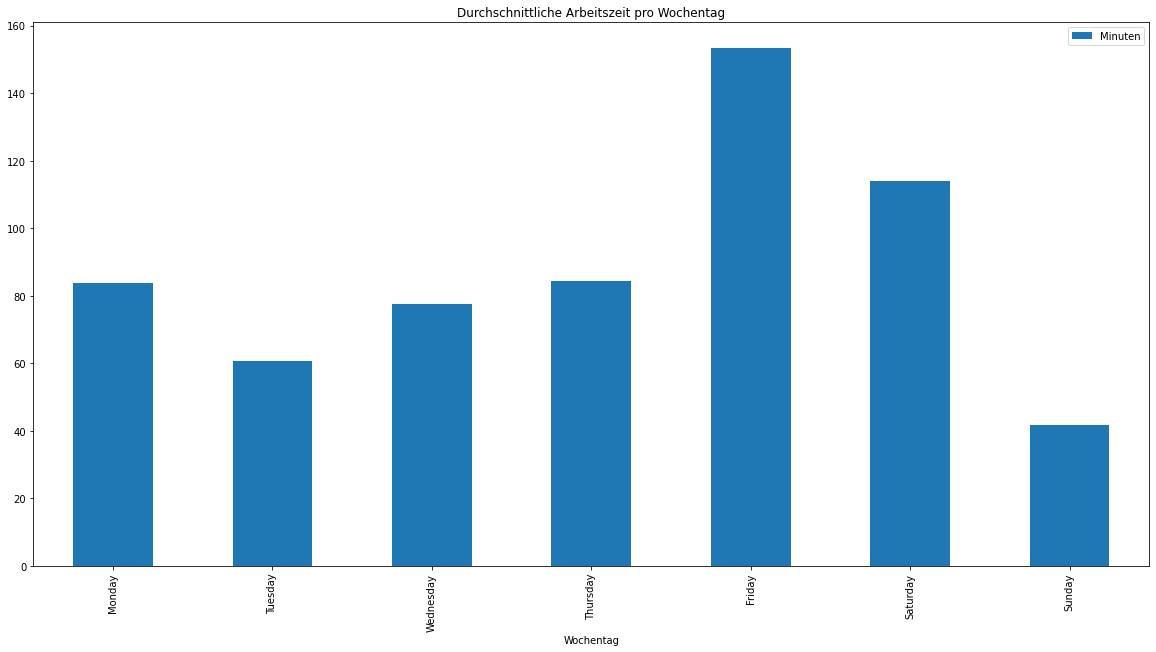

In [99]:
merged_grouped[['Minuten']].plot(kind='bar', figsize=(20,10), grid=False, title='Durchschnittliche Arbeitszeit pro Wochentag')